##設定

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
root_path = '/content/drive/MyDrive/NLP/data'

In [ ]:
# 再現性の確保
import torch
import random
import numpy as np

# シード値
seed = 42

# CPUおよびGPUの乱数生成器のシードを固定
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # マルチGPUを使用する場合

# CuDNNの挙動を決定論的に
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# NumPyの乱数生成器のシードを固定
np.random.seed(seed)

# Pythonの組み込み乱数生成器のシードを固定
random.seed(seed)


## 4.1

In [ ]:
# embedding
import numpy as np
W = np.arange(21).reshape(7, 3)
print(W)
print("\n")
print(W[2])
print("\n")
idx = [1, 0, 3, 2]
print(W[idx])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]


[6 7 8]


[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 6  7  8]]


In [ ]:
# pytorchでのEmbedding
import torch.nn as nn
embedding = nn.Embedding(num_embeddings=7, embedding_dim=3)
print(embedding)

Embedding(7, 3)


##PTBデータセットのダウンロード



In [ ]:
import os
import requests

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
files = ['ptb.train.txt', 'ptb.valid.txt', 'ptb.test.txt']

for file in files:

  save_path = root_path + "/" + file
  if os.path.exists(save_path):
    print(f"{file} already exists.")
    continue

  url = url_base + file
  response = requests.get(url)

  if response.status_code == 200:
    with open(save_path, "wb") as f:
      f.write(response.content)

      print(f"{file} downloaded and saved successfully.")

  else:
    print(f"{file} failed to download. Status code: {response.status_code}")

ptb.train.txt already exists.
ptb.valid.txt already exists.
ptb.test.txt already exists.


##コーパスの作成
- load_corpus：PTBデータセットを用いてcorpus, word_to_id, id_to_wordを作成


In [ ]:
files = ['ptb.train.txt']

In [ ]:
import numpy as np
from typing import List, Dict, Tuple

def load_corpus(files: List[str], root_path: str) -> Tuple[np.ndarray, Dict[str, int], Dict[int, str]]:
    word_to_id: Dict[str, int] = {}
    id_to_word: Dict[int, str] = {}

    for file in files:
        with open(root_path + '/' + file, "r") as ff:
            words = ff.read().replace("\n", "<eos>").strip().split()

            for word in words:
                if word not in word_to_id:
                    tmp_id = len(word_to_id)
                    word_to_id[word] = tmp_id
                    id_to_word[tmp_id] = word

    corpus: np.ndarray = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word



##Negative Sampling


In [ ]:
import numpy as np
import torch
from collections import Counter

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        # 'corpus' はnumpy配列
        counts = Counter(corpus)
        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)   # power=0.75乗することでレアな単語の確率が高くなる
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        # 'target' はtorch.Tensor
        if target.dim() == 0:
            target = target.unsqueeze(0)
        elif target.dim() == 2:
            target = target.view(-1)

        batch_size = target.size(0)
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i].item()  # targetからnumpy indexを取得
            p[target_idx] = 0
            p /= p.sum()

            negative_sample[i, :] = np.random.choice(self.vocab_size, self.sample_size, replace=False, p=p)

        # 'negative_sample' はtorch.Tensor
        negative_sample = torch.from_numpy(negative_sample).long()

        # 元の形状に戻す
        if target.dim() == 2:
            original_shape = target.size()
            negative_sample = negative_sample.view(original_shape[0], original_shape[1], self.sample_size)

        return negative_sample


##データの準備


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
corpus, word_to_id, id_to_word = load_corpus(files, root_path)

In [ ]:
# データ準備_1
class SkipDataset(Dataset):
  def __init__(self, corpus, window_size=5):
    self.corpus = corpus
    self.window_size = window_size
    self.target = torch.from_numpy(corpus[window_size:-window_size]).long()
    self.contexts = self._create_contexts(corpus, window_size)
    self.sampler = UnigramSampler(corpus, power=0.75, sample_size=5)

  def _create_contexts(self, corpus, window_size):
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    contexts = torch.stack([torch.tensor(c) for c in contexts])

    return contexts

  def __len__(self):

    return len(self.target)

  def __getitem__(self, idx):
    batch_inputs = self.target[idx]
    batch_positive = self.contexts[idx]
    batch_negative = self.sampler.get_negative_sample(batch_positive)


    return batch_inputs, batch_positive, batch_negative


In [ ]:
%%time
# データ準備2
corpus, word_to_id, id_to_word = load_corpus(files, root_path)
s_ptb_ds = SkipDataset(corpus, window_size=5)
s_ptb_dl = DataLoader(s_ptb_ds, batch_size=100, shuffle=True, drop_last=True)

CPU times: user 13.3 s, sys: 1.58 s, total: 14.9 s
Wall time: 14.3 s


In [ ]:
# 動作確認
for batch_inputs, batch_positive, batch_negative in s_ptb_dl:
    print("Target:", batch_inputs)
    print("Positive:", batch_positive)
    print("Negative Sample:", batch_negative)
    break


Target: tensor([1502, 9816,  528,   34,  653,   32,  798,   48,   39, 4430,  119,  229,
         307,   42,   26, 3612, 8453,  159, 1070, 7176,  714, 1190,   98,   24,
        1325, 1604, 2397,   26,   35,   32, 2816,  181,  108,   24,   24, 2411,
        5191,   56, 1359,   93,   42,  555, 9046,  152,  270,  683,   24,  706,
          26, 1590,   40, 1200, 3017, 2679,  167,  840,  501,   27, 7555,   93,
         169,  289, 2620,  227, 1725,  225,   32, 1619,   24,  371,   26, 7244,
          27,  563,  232,   35,  108,   64, 2658,  160,  365, 1026,   32,   98,
        3395, 1061,   88,  840, 1950,  159,  471, 7429,  130,   40,  159, 6140,
        3305,   56,  556,   32])
Positive: tensor([[4206,   24, 6816,   69,  365,   35, 1595,   48,   69,   98],
        [1162,   26,   48,   93,   32,  846,  910, 1128, 5550, 2346],
        [  40, 2005,   64, 1857,   32,  362,   24, 8363, 3003, 2107],
        [  32,  602,   48,  245, 2470,  428,   34,  209, 2704, 6166],
        [6767,   24, 2484, 28

In [ ]:
print(batch_inputs.shape)
print(batch_positive.shape)
print(batch_negative.shape)

torch.Size([100])
torch.Size([100, 10])
torch.Size([100, 10, 5])


## ニューラルネットワークの設計

In [ ]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    super().__init__()
    self.embeds_i = nn.Embedding(V, H)
    self.embeds_o = nn.Embedding(V, H)

  def forward(self, inputs, pos_samples, neg_samples):
    num_contexts = pos_samples.shape[1]
    num_negative_samples = neg_samples.shape[2]
    embeds_i = self.embeds_i(inputs).unsqueeze(1)
    embeds_p = self.embeds_o(pos_samples)
    embeds_n = self.embeds_o(neg_samples).view(-1, num_contexts * num_negative_samples, 100)

    # POS
    pos_score = torch.sum(embeds_i * embeds_p, dim=2)

    # NEG
    neg_score = torch.sum(embeds_i * embeds_n, dim=2)

    return pos_score.sigmoid(), neg_score.sigmoid()


##学習


In [ ]:
# checkpoint
def save_checkpoint(model, optimizer, epoch, save_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, save_path)


def load_checkpoint(model, optimizer, save_path):
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [ ]:
from tqdm import tqdm
import torch


def trainer(net, max_epochs=10, LR=0.001, verbose=True):
    # DataLoader
    dl_dict = {'train': s_ptb_dl}

    # initialize
    def weight_init(m):
        classname = m.__class__.__name__
        if classname.find('Embedding') != -1:
            with torch.no_grad():
                m.weight.data.normal_(0, 0.01)

    # device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    compute_device = "GPU" if device.type == "cuda" else "CPU"

    print(f"This is {compute_device} trainer !!")
    print("-"*20, 'Start', "-"*20)

    net.to(device)

    # initialize
    net.apply(weight_init)

    # train
    net.train()
    torch.backends.cudnn.benchmark = False

    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    LOSS = torch.zeros(max_epochs)
    ACC = torch.zeros(max_epochs)

    iteration = 0
    for epoch in range(max_epochs):
        phase = 'train'

        running_loss = 0.0
        correct_pred = 0
        total_pred = 0
        for batch_inputs, batch_positive, batch_negative in tqdm(dl_dict[phase]):
            inputs = batch_inputs.to(device)
            pos_samples = batch_positive.to(device)
            neg_samples = batch_negative.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                pos_s, neg_s = net(inputs, pos_samples, neg_samples)
                loss = -torch.log(pos_s + 1e-10).sum() - torch.log(1 - neg_s + 1e-10).sum()

                # 正解数をカウント
                predictions = pos_s >= 0.5                 # True/Falseを保存
                correct_pred += predictions.sum().item()   # Trueの合計(各エポックでの正解数)
                total_pred += predictions.numel()          # predictionsの要素数(Falseを含む)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

            iteration += 1
            if iteration % 1000 == 0:
              # check point
              save_path = f'/content/drive/MyDrive/NLP/CheckPoint/checkpoint_epoch_{epoch + 1}_iter_{iteration}.pth'
              save_checkpoint(net, optimizer, epoch, save_path)

        LOSS[epoch] = running_loss / len(dl_dict[phase].dataset)
        ACC[epoch] = correct_pred / total_pred

        if verbose:
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Accuracy: {:.4f}'.format(
                epoch+1,
                max_epochs,
                phase,
                LOSS[epoch],
                ACC[epoch])
            )

    return net, LOSS, ACC

In [ ]:
net1 = SkipGram(vocab_size=len(word_to_id), hidden_size=100)

In [ ]:
%%time
trained_net1, LOSS_1, ACC_1 = trainer(net1, max_epochs=10, LR=0.001, verbose=True)

This is GPU trainer !!
-------------------- Start --------------------


100%|██████████| 9295/9295 [34:15<00:00,  4.52it/s]


Epoch 1/10 | train | Loss: 25.2884 | Accuracy: 0.0411


100%|██████████| 9295/9295 [34:25<00:00,  4.50it/s]


Epoch 2/10 | train | Loss: 23.8493 | Accuracy: 0.0655


100%|██████████| 9295/9295 [34:14<00:00,  4.52it/s]


Epoch 3/10 | train | Loss: 23.4814 | Accuracy: 0.0810


100%|██████████| 9295/9295 [34:30<00:00,  4.49it/s]


Epoch 4/10 | train | Loss: 23.2324 | Accuracy: 0.0918


100%|██████████| 9295/9295 [34:25<00:00,  4.50it/s]


Epoch 5/10 | train | Loss: 23.0448 | Accuracy: 0.0991


100%|██████████| 9295/9295 [34:34<00:00,  4.48it/s]


Epoch 6/10 | train | Loss: 22.9007 | Accuracy: 0.1044


100%|██████████| 9295/9295 [34:36<00:00,  4.48it/s]


Epoch 7/10 | train | Loss: 22.7894 | Accuracy: 0.1086


100%|██████████| 9295/9295 [33:59<00:00,  4.56it/s]


Epoch 8/10 | train | Loss: 22.7020 | Accuracy: 0.1120


100%|██████████| 9295/9295 [34:47<00:00,  4.45it/s]


Epoch 9/10 | train | Loss: 22.6320 | Accuracy: 0.1149


100%|██████████| 9295/9295 [34:29<00:00,  4.49it/s]

Epoch 10/10 | train | Loss: 22.5795 | Accuracy: 0.1171
CPU times: user 5h 43min 58s, sys: 1min 4s, total: 5h 45min 2s
Wall time: 5h 44min 20s


In [ ]:
trained_net1.cpu()

SkipGram(
  (embeds_i): Embedding(10000, 100)
  (embeds_o): Embedding(10000, 100)
)

In [ ]:
save_path = '/content/drive/MyDrive/NLP/trained_model/trained_net1.pth'
torch.save(trained_net1.state_dict(), save_path)

In [ ]:
LOSS_1.cpu()
ACC_1.cpu()

tensor([0.0411, 0.0655, 0.0810, 0.0918, 0.0991, 0.1044, 0.1086, 0.1120, 0.1149,
        0.1171])

In [ ]:
loss_1_path = '/content/drive/MyDrive/NLP/metrics/loss_1.npy'
acc_1_path = '/content/drive/MyDrive/NLP/metrics/acc_1.npy'

np.save(loss_1_path, LOSS_1)
np.save(acc_1_path, ACC_1)

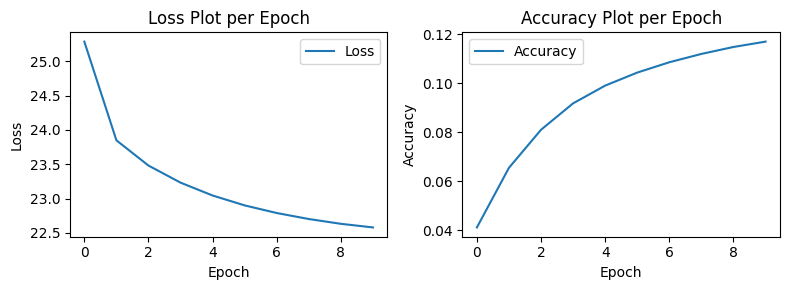

In [ ]:
# loss, acc
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(LOSS_1.numpy(), label="Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Plot per Epoch")
ax1.legend()

ax2.plot(ACC_1.numpy(), label='Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Plot per Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

## skip-gramモデルの評価
###ここでは次の二つの方法で評価していきます。
- ベクトルの類似度：単語ベクトル同士の類似度を計算して私たちの感覚と合致するか確認します
- 類推問題：king：man = queen：? のような問題が解けるのかを確認します

In [ ]:
# 単語ベクトル
weights_1 = trained_net1.state_dict()
in_embeds_weights_1 = weights_1['embeds_i.weight']
print(in_embeds_weights_1.shape)

torch.Size([10000, 100])


In [ ]:
# 評価関数の定義
# 以下のレポジトリを参考にしました
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/util.py
import numpy
import torch
import torch.nn.functional as F

def cos_sim(x, y):
  return F.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0)).item()

def most_sim(query, word_to_id, id_to_word, word_matrix, top=5):
  if query not in word_to_id:
    print(f'{query} is not found.')
    return

  print('\n[query]' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  vocab_size = word_matrix.shape[0]

  # similarity
  similarity = torch.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_sim(word_matrix[i], query_vec)

  # display
  count = 0
  for i in (-1 * similarity).argsort().cpu().numpy():
    if id_to_word[i] == query:
      continue

    print('%s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return


In [ ]:
# 類似度の表示
query = ["you", "year", "car", "toyota"]
for q in query:
  most_sim(q, word_to_id, id_to_word, in_embeds_weights_1, top=5)


[query]you
yourself: tensor(0.6878)
we: tensor(0.6646)
i: tensor(0.6602)
your: tensor(0.6270)
anybody: tensor(0.6187)

[query]year
month: tensor(0.6730)
earlier: tensor(0.6048)
quarter: tensor(0.5665)
week: tensor(0.5339)
period: tensor(0.5312)

[query]car
cars: tensor(0.6358)
luxury: tensor(0.6299)
lexus: tensor(0.5255)
auto: tensor(0.5098)
mazda: tensor(0.5078)

[query]toyota
honda: tensor(0.7069)
lexus: tensor(0.6661)
motor: tensor(0.6510)
infiniti: tensor(0.6447)
beretta: tensor(0.6201)


In [ ]:
# 類推問題
# 以下のレポジトリを参考にしました
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/util.py

import torch
from typing import Dict

def analogy(a: str, b: str, c: str, word_to_id: Dict[str, int], id_to_word: Dict[int, str], word_matrix: torch.Tensor, top: int = 5, answer: str = None):
  for word in (a, b, c):
    if word not in word_to_id:
      print(f'{word} is not found.')
      return

  print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
  a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
  query_vec = b_vec - a_vec + c_vec
  query_vec = normalize(query_vec)

  # similarity
  similarity = torch.mv(word_matrix, query_vec)

  if answer is not None:
    print('==>' + answer + ':' + str(torch.dot(word_matrix[word_to_id[answer]], query_vec)))

  # display
  count = 0
  for i in (-1 * similarity).argsort().cpu().numpy():
    if torch.isnan(similarity[i]):
      continue

    if id_to_word[i] in (a, b, c):
      continue

    print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

def normalize(x: torch.Tensor) -> torch.Tensor:
  # テンソルの正規化
  return x / torch.sqrt((x ** 2).sum())

In [ ]:
# 類推問題を解く
analogy('man', 'king', 'woman', word_to_id, id_to_word, in_embeds_weights_1, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, in_embeds_weights_1, top=5)
analogy('child', 'children', 'car', word_to_id, id_to_word, in_embeds_weights_1, top=5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, in_embeds_weights_1, top=5)


[analogy] man:king = woman:?
 burger: 2.098606586456299
 c.d.s: 1.9212957620620728
 epo: 1.6647698879241943
 high-definition: 1.6322184801101685
 free-lance: 1.5642573833465576

[analogy] take:took = go:?
 plunged: 1.6180332899093628
 amsterdam: 1.4984995126724243
 bounced: 1.441969394683838
 tall: 1.4354044198989868
 marched: 1.3598862886428833

[analogy] child:children = car:?
 trucks: 1.9554028511047363
 cars: 1.909703016281128
 jaguar: 1.8125091791152954
 luxury: 1.7788041830062866
 pricings: 1.6930049657821655

[analogy] good:better = bad:?
 vary: 1.5026973485946655
 hart-scott-rodino: 1.47996985912323
 clobbered: 1.4320815801620483
 swings: 1.4099304676055908
 influenced: 1.4086573123931885


In [ ]:
import gc
del s_ptb_ds, s_ptb_dl

torch.cuda.empty_cache()
gc.collect()

3300

##補足：CBOWモデルとの比較

In [ ]:
class CBOWDataset(Dataset):
  def __init__(self, corpus, window_size=5):
    self.corpus = corpus
    self.window_size = window_size
    self.target = torch.from_numpy(corpus[window_size:-window_size]).long()
    self.contexts = self._create_contexts(corpus, window_size)
    self.sampler = UnigramSampler(corpus, power=0.75, sample_size=5)

  def _create_contexts(self, corpus, window_size):
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    contexts = torch.stack([torch.tensor(c) for c in contexts])

    return contexts

  def __len__(self):

    return len(self.target)

  def __getitem__(self, idx):
    batch_inputs = self.contexts[idx]
    batch_positive = self.target[idx]
    batch_negative = self.sampler.get_negative_sample(batch_positive)
    batch_negative = batch_negative.squeeze(0)

    return batch_inputs, batch_positive, batch_negative

In [ ]:
%%time
# corpus, word_to_id, id_to_word = load_corpus(files, root_path)
c_ptb_ds = CBOWDataset(corpus, window_size=5)
c_ptb_dl = DataLoader(c_ptb_ds, batch_size=100, shuffle=True, drop_last=True)

CPU times: user 13.1 s, sys: 1.27 s, total: 14.3 s
Wall time: 13.8 s


In [ ]:
# 動作確認
for batch_inputs, batch_positive, batch_negative in c_ptb_dl:
    print("Input:", batch_inputs)
    print("Positive:", batch_positive)
    print("Negative Sample:", batch_negative)
    break

Input: tensor([[1153,  251, 1129,   64, 1015, 2361,   98, 2640, 3344, 1761],
        [  80,   35, 2721,  274,  142, 1363,  133,  974, 7099,   24],
        [ 467,  413,  546,   24, 2177,  874,  674,   32,  346,  119],
        [1959,   64,  220, 3078,  181, 2023,   24,   48,  142,  247],
        [  48,   32, 1971, 2106,   26,   48,   26,   24, 7868,   72],
        [4480,   26,  154,  775,   64, 8918,  289, 1123, 1380,   24],
        [1112,  284,   32, 1294, 1328, 1354,  853, 8517,   26,  128],
        [ 148, 1134,   32,  617,   24,   32,   26, 2544, 1567,   56],
        [2802, 1321,   42,  109,  182, 2685,   32,  594,   42,   32],
        [3280, 1003,   93,  113,  108,   87, 1140,  360,  867,   24],
        [3737,  853, 3455,   26,   32,   42, 1516,  119,  151,  798],
        [1338,   48,   54,  251,  895, 1158,   24,  225,   98,  225],
        [ 970,  432, 1802,   64, 2004, 2867,  853,  861,   26,  312],
        [ 750,   40, 1975,   48,   26, 2289,  251, 7459,  885,   95],
        [  24

In [ ]:
print(batch_inputs.shape)
print(batch_positive.shape)
print(batch_negative.shape)

torch.Size([100, 10])
torch.Size([100])
torch.Size([100, 5])


In [ ]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    super().__init__()
    self.embeds_i = nn.Embedding(V, H)
    self.embeds_o = nn.Embedding(V, H)

  def forward(self, inputs, pos_samples, neg_samples):
    embeds_i = self.embeds_i(inputs)
    mean_embeds_i = torch.mean(embeds_i, dim=1, keepdim=True)

    num_context_words = inputs.shape[1]        # 2 * window_size = 10
    num_negative_words = neg_samples.shape[1]  # sample_size = 5

    embeds_p = self.embeds_o(pos_samples).view(-1, 1, 100)
    embeds_n = self.embeds_o(neg_samples)

    # POS
    pos_score = torch.sum(mean_embeds_i * embeds_p, dim=2)

    # NEG
    neg_score = torch.sum(mean_embeds_i * embeds_n, dim=2)

    return pos_score.sigmoid(), neg_score.sigmoid()

In [ ]:
from tqdm import tqdm

def trainer(net, max_epochs=10, LR=0.001, verbose=True):
  # DataLoade
  dl_dict = {'train': c_ptb_dl}

  # initialize
  def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Embedding') != -1:
      with torch.no_grad():
        m.weight.data.normal_(0, 0.01)

  # device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  compute_device = "GPU" if device.type == "cuda" else "CPU"

  print(f"This is {compute_device} trainer !!")
  print("-"*20, 'Start', "-"*20)

  net.to(device)

  # initialize
  net.apply(weight_init)

  # train
  net.train()
  torch.backends.cudnn.benchmark = False

  optimizer = torch.optim.Adam(net.parameters(), lr=LR)
  LOSS = torch.zeros(max_epochs)
  ACC = torch.zeros(max_epochs)

  for epoch in range(max_epochs):
    phase = 'train'

    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    for batch_inputs, batch_positive, batch_negative in tqdm(dl_dict[phase]):
      inputs = batch_inputs.to(device)
      pos_samples = batch_positive.to(device)
      neg_samples = batch_negative.to(device)

      optimizer.zero_grad()
      with torch.set_grad_enabled(phase=='train'):
        pos_s, neg_s = net(inputs, pos_samples, neg_samples)
        loss = -torch.log(pos_s + 1e-10).sum() - torch.log(1 - neg_s + 1e-10).sum()

        # 正解数をカウント
        # pos_s >= 0.5で正とみなす
        predictions = pos_s >= 0.5                 # True/Falseを保存
        correct_pred += predictions.sum().item()   # Trueの合計(各エポックでの正解数)
        total_pred += predictions.numel()          # predictionsの要素数(Falseを含む)

        if phase == 'train':
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

    LOSS[epoch] = running_loss / len(dl_dict[phase].dataset)
    ACC[epoch] = correct_pred / total_pred

    if verbose:
      print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Accuracy: {:.4f}'.format(
          epoch+1,
          max_epochs,
          phase,
          LOSS[epoch],
          ACC[epoch])
      )


  return net, LOSS, ACC


In [ ]:
net2 = CBOW(vocab_size=len(word_to_id), hidden_size=100)

In [ ]:
%%time
trained_net2, LOSS_2, ACC_2 = trainer(net2, max_epochs=10, LR=0.001, verbose=True)

This is GPU trainer !!
-------------------- Start --------------------


100%|██████████| 9295/9295 [04:41<00:00, 33.00it/s]


Epoch 1/10 | train | Loss: 2.4231 | Accuracy: 0.1071


100%|██████████| 9295/9295 [04:44<00:00, 32.62it/s]


Epoch 2/10 | train | Loss: 2.0895 | Accuracy: 0.2562


100%|██████████| 9295/9295 [04:43<00:00, 32.81it/s]


Epoch 3/10 | train | Loss: 1.9213 | Accuracy: 0.3360


100%|██████████| 9295/9295 [04:41<00:00, 32.96it/s]


Epoch 4/10 | train | Loss: 1.8080 | Accuracy: 0.3866


100%|██████████| 9295/9295 [04:45<00:00, 32.60it/s]


Epoch 5/10 | train | Loss: 1.7200 | Accuracy: 0.4251


100%|██████████| 9295/9295 [04:40<00:00, 33.18it/s]


Epoch 6/10 | train | Loss: 1.6465 | Accuracy: 0.4579


100%|██████████| 9295/9295 [04:38<00:00, 33.37it/s]


Epoch 7/10 | train | Loss: 1.5844 | Accuracy: 0.4854


100%|██████████| 9295/9295 [04:38<00:00, 33.41it/s]


Epoch 8/10 | train | Loss: 1.5301 | Accuracy: 0.5102


100%|██████████| 9295/9295 [04:46<00:00, 32.39it/s]


Epoch 9/10 | train | Loss: 1.4819 | Accuracy: 0.5315


100%|██████████| 9295/9295 [04:45<00:00, 32.53it/s]

Epoch 10/10 | train | Loss: 1.4389 | Accuracy: 0.5506
CPU times: user 46min 56s, sys: 14.2 s, total: 47min 10s
Wall time: 47min 6s


In [ ]:
# trained_net2.cpu()
save_path = '/content/drive/MyDrive/NLP/trained_model/trained_net2.pth'
torch.save(trained_net1.state_dict(), save_path)

In [ ]:
LOSS_2.cpu()
ACC_2.cpu()

tensor([0.1071, 0.2562, 0.3360, 0.3866, 0.4251, 0.4579, 0.4854, 0.5102, 0.5315,
        0.5506])

In [ ]:
loss_2_path = '/content/drive/MyDrive/NLP/metrics/loss_2.npy'
acc_2_path = '/content/drive/MyDrive/NLP/metrics/acc_2.npy'

np.save(loss_2_path, LOSS_2)
np.save(acc_2_path, ACC_2)

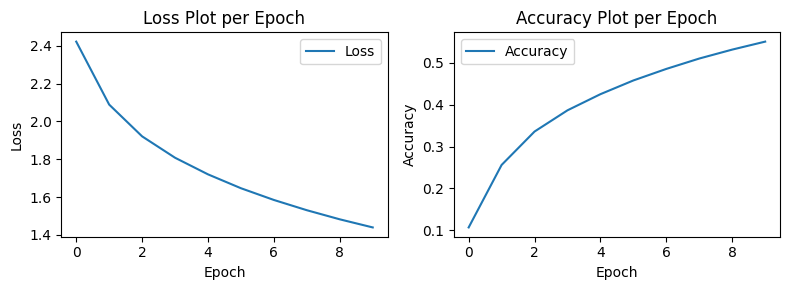

In [ ]:
# loss, acc
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(LOSS_2.numpy(), label="Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Plot per Epoch")
ax1.legend()

ax2.plot(ACC_2.numpy(), label='Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Plot per Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 単語ベクトル
weights_2 = trained_net2.state_dict()
in_embeds_weights_2 = weights_2['embeds_i.weight']
print(in_embeds_weights_2.shape)

torch.Size([10000, 100])


In [ ]:
# 類似度の表示
query = ["you", "year", "car", "toyota"]
for q in query:
  most_sim(q, word_to_id, id_to_word, in_embeds_weights_2, top=5)


[query]you
i: tensor(0.7352)
we: tensor(0.7104)
your: tensor(0.5906)
they: tensor(0.5889)
anything: tensor(0.5822)

[query]year
month: tensor(0.8466)
summer: tensor(0.7755)
week: tensor(0.7663)
spring: tensor(0.7523)
decade: tensor(0.6996)

[query]car
auto: tensor(0.6323)
luxury: tensor(0.6277)
truck: tensor(0.6095)
merkur: tensor(0.5919)
window: tensor(0.5767)

[query]toyota
seita: tensor(0.6720)
mazda: tensor(0.6433)
honda: tensor(0.6307)
weyerhaeuser: tensor(0.6184)
minicomputers: tensor(0.6140)


In [ ]:
# 類推問題を解く
analogy('man', 'king', 'woman', word_to_id, id_to_word, in_embeds_weights_2, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, in_embeds_weights_2, top=5)
analogy('child', 'children', 'car', word_to_id, id_to_word, in_embeds_weights_2, top=5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, in_embeds_weights_2, top=5)


[analogy] man:king = woman:?
 horse: 4.003708839416504
 award: 3.576308488845825
 artist: 3.5618441104888916
 university: 3.5534729957580566
 hat: 3.530251979827881

[analogy] take:took = go:?
 went: 4.682293891906738
 were: 4.424361705780029
 're: 4.414312839508057
 came: 4.238278388977051
 began: 3.981295347213745

[analogy] child:children = car:?
 cars: 4.633687496185303
 vehicles: 4.376805782318115
 makers: 4.095094203948975
 outlets: 4.085973739624023
 plants: 4.07045316696167

[analogy] good:better = bad:?
 rather: 5.697723388671875
 less: 5.421773910522461
 more: 5.351481914520264
 greater: 4.385748386383057
 worse: 4.04022216796875


In [ ]:
model_path_1 = '/content/drive/MyDrive/NLP/trained_model/trained_net1.pth'
model_path_2 = '/content/drive/MyDrive/NLP/trained_model/trained_net2.pth'

loss_1_path = '/content/drive/MyDrive/NLP/metrics/loss_1.npy'
acc_1_path = '/content/drive/MyDrive/NLP/metrics/acc_1.npy'

loss_2_path = '/content/drive/MyDrive/NLP/metrics/loss_2.npy'
acc_2_path = '/content/drive/MyDrive/NLP/metrics/acc_2.npy'

trained_net1 = torch.load_state_dict(model_path_1)
trained_net2 = torch.load_state_dict(model_path_2)

LOSS_1 = np.load(loss_1_path)
ACC_1 = np.load(acc_1_path)

LOSS_2 = np.load(loss_2_path)
ACC_2 = np.load(acc_2_path)
